<h1>Capstone Project Report - Housing</h1>
<h2>Problem</h2>
<p>Homeownership has long had social benefits including greater happiness and prosperity levels, higher civic participation rates, and better education outcomes. When considering whether or not to purchase a house, the prospective buyer looks not just at the price but also factors such as square footage and certain numbers of rooms such as bedrooms and bathrooms.  The goal is to determine what factors have the greatest influence on housing prices.</p>

<p>The main clients of this analysis include homebuyers, business owners and managers, and government officials. This data can help prospective buyers make more informed decisions about purchasing a house if they can see how much house they would get for the money they pay. Higher homeownership rates are associated with greater stability, so the data can be useful for business owners and managers in finding areas to set up shop. Government officials can also use the data to come up with policies that improve housing affordability.</p>

<h2>Data Wrangling</h2>
<p>The data comes from Kaggle and was collected in 2011. The dataset contains 80 variables about attributes of 2,390 properties in Ames, Iowa. This dataset was accessed from https://kaggle.com/c/house-prices-advanced-regression-techniques/data</p>

<p>My first step was to isolate only the values that can be useful in a linear regression analysis. This dataframe consisted of variables such as quality and condition, square footage, and number of bathrooms. These columns were renamed to make them easier to understand. The Garage and FenceType columns were converted to strings, and the variables that had letters in their entries were converted to numbers depending on the rating. For example, a poor rating would be replaced by a 1 and an excellent rating would have a rating of 5. Values in FenceType and Pool that were 'Nan' were replaced with zeroes.</p>

<h2>Feature Engineering</h2>
<p>To finish preparing the dataset for exploratory analysis and machine learning, some feature engineering steps were performed. These included calculating the age of the house by subtracting the year the house was built from the year the data were collected. The half and full bathrooms were combined to make one bathroom variable, and all the porch variables were combined into one porch variable. The first floor, second floor, and basement areas were also combined into an overall square footage variable.</p>

<p>Missing values were imputed with the median.</p>

<h2>Exploratory Data Analysis</h2>
<p>I plotted the sales prices against the different variables to see if significant correlations could be found between the variable and the sale prices. After plotting a correlation heat map, I could see a negative correlation in the plots of sale price against the age of the house, and positive correlations in the plots of sale price against the greater living area, overall quality, and basement condition.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import ttest_ind

from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [2]:
housing = pd.read_csv('housing_cleaned_1.csv')

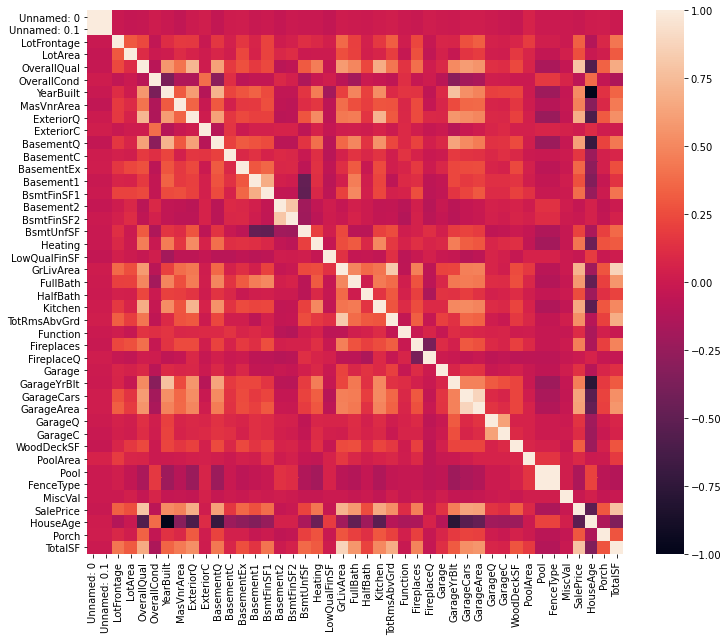

In [3]:
#correlation matrix (corr function)
plt.subplots(figsize=(12,10))
sns.heatmap(housing.corr());

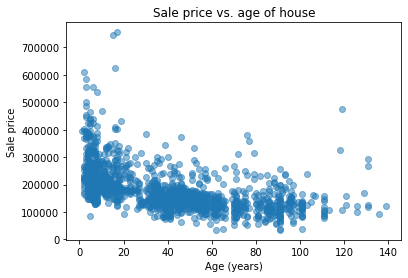

In [4]:
plt.scatter(housing['HouseAge'], housing['SalePrice'], alpha=0.5)
plt.title('Sale price vs. age of house')
plt.xlabel('Age (years)')
plt.ylabel('Sale price')
plt.show()

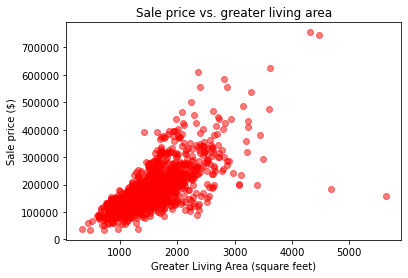

In [5]:
plt.scatter(housing['GrLivArea'], housing['SalePrice'], color='red', alpha=0.5)
plt.title('Sale price vs. greater living area')
plt.xlabel('Greater Living Area (square feet)')
plt.ylabel('Sale price ($)')
plt.show()

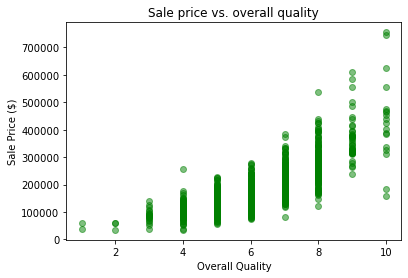

In [6]:
plt.scatter(housing['OverallQual'], housing['SalePrice'], color='green', alpha=0.5)
plt.title('Sale price vs. overall quality')
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price ($)')
plt.show()

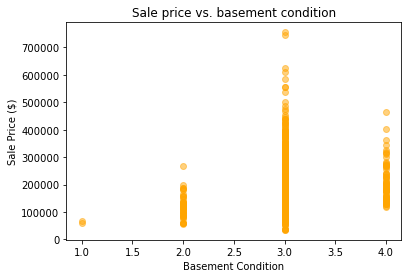

In [7]:
plt.scatter(housing['BasementC'], housing['SalePrice'], color='orange', alpha=0.5)
plt.title('Sale price vs. basement condition')
plt.xlabel('Basement Condition')
plt.ylabel('Sale Price ($)')
plt.show()

<h2>Predictive Analysis</h2>

I tested four different machine learning models: Linear Regression, Ordinary Least Squares, Random Forest Classifier, and SVR. Before building the models, I used Lasso to select the more important features.

In [8]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
#Splitting dataset into independent and dependent variables
X = housing.drop(['SalePrice'], axis=1)
y = housing['SalePrice']

In [10]:
# Splitting into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

In [11]:
# feature names in a list
feature_names_train = [x for x in X_train.columns]
feature_names_test = [x for x in X_test.columns]

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Convert back to dataframe
X_train = pd.DataFrame(data = X_train, columns = feature_names_train)
X_test = pd.DataFrame(data = X_test, columns = feature_names_test)

In [12]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [13]:
clf = Lasso(alpha=0.005, random_state=0)

In [14]:
feature_sel_model = SelectFromModel(clf, threshold=0.25)
feature_sel_model.fit(X_train, y_train)

C:\Users\saraa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 399176387081.02966, tolerance: 615098412.8205527
  model = cd_fast.enet_coordinate_descent(


SelectFromModel(estimator=Lasso(alpha=0.005, random_state=0), threshold=0.25)

In [15]:
X_train = feature_sel_model.transform(X_train)
X_test = feature_sel_model.transform(X_test)

<strong>(1) Linear Regression</strong>

In [16]:
#Fit the model
from sklearn.linear_model import LinearRegression
LinearRegressor = LinearRegression()
LinearRegressor.fit(X_train, y_train)

LinearRegression()

In [17]:
#Calculate the R2 score
from sklearn.metrics import r2_score
y_pred = LinearRegressor.predict(X_test)
Linear_Regression_Score = r2_score(y_test, y_pred)
Linear_Regression_Score

0.8359781242064662

In [18]:
from sklearn.metrics import mean_squared_error
MSE_LR = mean_squared_error(y_test, y_pred, squared = False)
MSE_LR

33831.34682705405

Text(0, 0.5, 'Prediction')

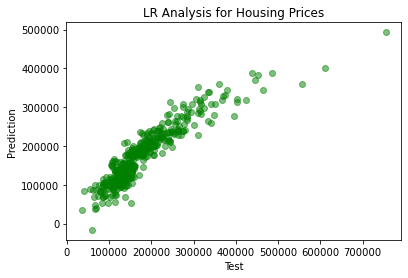

In [19]:
plt.scatter(y_test, y_pred, color='green', alpha=0.5)
plt.title('LR Analysis for Housing Prices')
plt.xlabel('Test')
plt.ylabel('Prediction')

There is a positive correlation here, but as the plot shows, houses that cost over 400,000 are predicted to have lower prices. Let's see if we can build a better model.

<strong>(2) Ordinary Least Squares</strong>

In [20]:
# Adding a constant to X is necessary for Ordinary Least Squares Regression.
X = sm.add_constant(X)

In [21]:
housing_ols = sm.OLS(y_train, X_train)
housing_ols_results = housing_ols.fit()
housing_ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     108.4
Date:                Mon, 08 Feb 2021   Prob (F-statistic):          3.53e-321
Time:                        06:13:25   Log-Likelihood:                -12115.
No. Observations:                1022   AIC:                         2.431e+04
Df Residuals:                     983   BIC:                         2.450e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -3893.6116   3792.637     -1.027      0.305   -1.13e+04    3548.985
x2         -4660.0872   1.64e+04     -0.285      0.776   -3.68e+04    2.75e+04
x3          8.257e+04   2.36e+04      3.504      0.000    3.63e+04    1.29e+05
x4          1.065e+05   1.38e+04      7.705      0.000    7.94e+04    1.34e+05
x5          3.292e+04   1.01e+04      3.275      0.001    1.32e+04    5.26e+04
x6         -1.081e+05   1.97e+04     -5.476      0.000   -1.47e+05   -6.94e+04
x7          2.432e+04   1.03e+04      2.351      0.019    4022.737    4.46e+04
x8          3.252e+04   9817.042      3.312      0.001    1.33e+04    5.18e+04
x9         -1.566e+04   1.37e+04     -1.145      0.252   -4.25e+04    1.12e+04
x10         4.322e+04   7855.053      5.502      0.000    2.78e+04    5.86e+04
x11        -6016.4803   1.23e+04     -0.490      0.624   -3.01e+04    1.81e+04
x12          1.51e+04   3638.538      4.151      0.000    7963.848    2.22e+04
x13         8160.4718   4098.248      1.991      0.047     118.152    1.62e+04
x14         4.818e+04    2.1e+04      2.293      0.022    6954.031    8.94e+04
x15        -4451.9743   1.12e+04     -0.396      0.692   -2.65e+04    1.76e+04
x16         1.281e+04   1.44e+04      0.887      0.375   -1.55e+04    4.11e+04
x17         8437.5769   9309.992      0.906      0.365   -9832.166    2.67e+04
x18         9562.5348   5892.201      1.623      0.105   -2000.204    2.11e+04
x19         3949.2945    1.4e+04      0.282      0.778   -2.35e+04    3.14e+04
x20         1.303e+05   2.52e+04      5.174      0.000    8.09e+04     1.8e+05
x21         1.933e+04    1.2e+04      1.608      0.108   -4260.241    4.29e+04
x22         5192.1503   5187.416      1.001      0.317   -4987.533    1.54e+04
x23         2.848e+04   8071.493      3.528      0.000    1.26e+04    4.43e+04
x24         3.172e+04   1.53e+04      2.073      0.038    1699.515    6.17e+04
x25         2.289e+04   1.01e+04      2.272      0.023    3118.665    4.27e+04
x26         3.078e+04   6836.956      4.501      0.000    1.74e+04    4.42e+04
x27         2.053e+04   8445.215      2.431      0.015    3956.664    3.71e+04
x28        -1006.2688   8802.760     -0.114      0.909   -1.83e+04    1.63e+04
x29        -5643.7123   9126.600     -0.618      0.536   -2.36e+04    1.23e+04
x30         4.851e+04    1.4e+04      3.468      0.001    2.11e+04     7.6e+04
x31         7263.2147   1.73e+04      0.419      0.675   -2.68e+04    4.13e+04
x32          4.78e+04   2.39e+04      1.998      0.046     862.262    9.47e+04
x33        -8916.6578   2.47e+04     -0.360      0.719   -5.75e+04    3.96e+04
x34         1.189e+04   7903.856      1.504      0.133   -3619.241    2.74e+04
x35        -2.763e+04   2.27e+04     -1.219      0.223   -7.21e+04    1.68e+04
x36         4298.4819   3884.123      1.107      0.269   -3323.645    1.19e+04
x3

In [22]:
y_pred = housing_ols_results.predict(X_test)

Text(0, 0.5, 'Fixed.acidity')

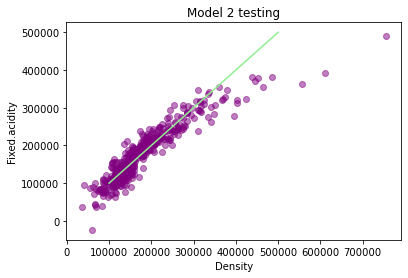

In [23]:
plt.scatter(y_test, y_pred, color='purple', alpha=0.5)

plt.plot([x for x in range(100000,500000)],[x for x in range(100000,500000)], color='lightgreen')

plt.title('Model 2 testing')
plt.xlabel('Density')
plt.ylabel('Fixed.acidity')

The R2 score for Ordinary Least Squares shows about 80% of the variance is explained by this model. Let's see if we can get a better result using multiple linear regression.

<strong>(3) Random Forest Regressor</strong>

In [24]:
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor()
RFR.fit(X_train,y_train)

RandomForestRegressor()

In [25]:
y_pred_RFR = RFR.predict(X_test)
RFR_Score = r2_score(y_test, y_pred_RFR)
RFR_Score

0.9001767406400504

In [26]:
MSE_RFR = mean_squared_error(y_test, y_pred_RFR, squared = False)
MSE_RFR

26392.727470579674

<strong>(4) SVR</strong>

In [27]:
from sklearn.svm import SVR
SVReg = SVR(kernel = 'rbf')
SVReg.fit(X_train, y_train)

SVR()

In [28]:
y_pred_SVR = SVReg.predict(X_test)
SVR_Score = r2_score(y_test, y_pred_SVR)
SVR_Score

-0.03120565435172762

In [29]:
MSE_SVR = mean_squared_error(y_test, y_pred_SVR, squared = False)
MSE_SVR

84828.35459253659

The random forest regressor model is the best of the models I tried because it showed the highest R2 score, with about 89% of the variance explained by the model, and the lowest mean squared error, of 27,274. SVR is the worst of the models in this report because of its low R2 score, -0.03, and high mean squared error of 84,828.

In [30]:
best_feat = np.abs(housing.corr()['SalePrice'])
best_feat_corr = pd.DataFrame(best_feat[:-1]).sort_values('SalePrice',ascending=False)
best_feat_corr

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
ExteriorQ,0.682639
Kitchen,0.659600
GarageCars,0.640409
GarageArea,0.623431
BasementQ,0.617356
FullBath,0.582934
TotRmsAbvGrd,0.533723


Text(0, 0.5, 'Features')

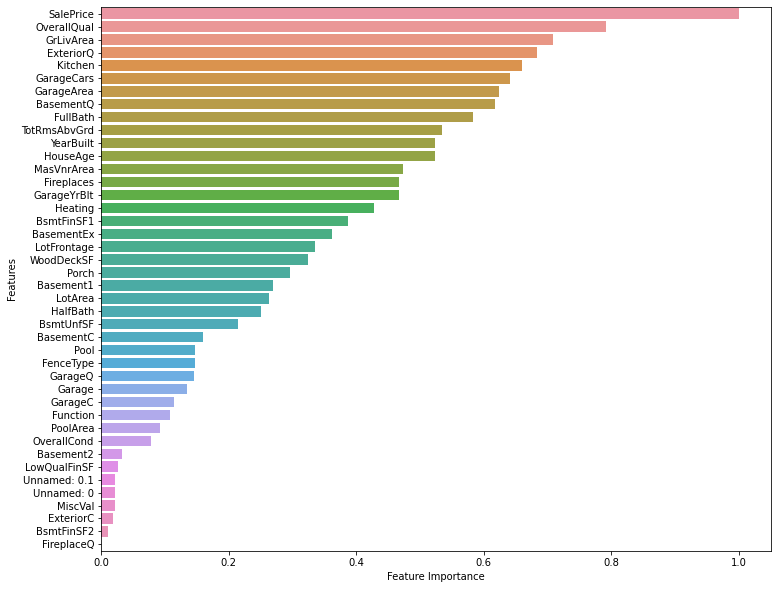

In [31]:
plt.figure(figsize=(12,10))
sns.barplot(x=best_feat_corr['SalePrice'], y=best_feat_corr.index)
plt.xlabel('Feature Importance')
plt.ylabel('Features')

<h2>Conclusions</h2>

<p>The most important features that influence housing prices are overall quality, greater living area, exterior quality, kitchen, and garage area.</p>

<p>These features may not tell the whole story about housing prices. Other external factors can influence housing prices such as geography, population, crime rates, and proximity to schools.</p>

<p>Also, since the data is 10 years old, finding data that's more recent may help with predicting housing prices.